In [177]:
%pylab inline
import xarray as xr
from tqdm import tqdm_notebook
import sys
import matplotlib.dates as mdates

rcParams["figure.figsize"] = [14, 10]
rcParams["figure.dpi"] = 100

font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 20}

matplotlib.rc('font', **font)

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator(interval=1)  # every month
weeks = mdates.WeekdayLocator(byweekday=MO, interval=2)
yearsFmt = mdates.DateFormatter("%d.%m")

Populating the interactive namespace from numpy and matplotlib


Load EN4 data

In [2]:
path = '/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/OI_L09_1989_2020/*.nc'

oi_data = xr.open_mfdataset(path)

Cut on lats to only include up to 20S

In [3]:
oi_data = oi_data.sel(lat=slice(oi_data.lat.min(), 0), depth=oi_data.depth[0])

Resample data to yearly to get a yearly trend line

In [4]:
oi_data_yr = oi_data.resample(time="1Y").mean()

Define calculation for the trendline

In [5]:
np.seterr(divide='ignore', invalid='ignore')

data = oi_data

trend_T = np.ndarray([len(data.lat), len(data.lon)])
trend_S = np.ndarray([len(data.lat), len(data.lon)])

lons = data.lon.values
lats = data.lat.values

xs = np.arange(len(data.time))

t = data.temperature.values
s = data.salinity.values

In [6]:
for i, ln in enumerate(lons):
    
    for ii, lt in enumerate(lats):
        
        yt = t[:, ii, i]
        
        if np.nanmin(yt) > 0:
        
            ys = s[:, ii, i]
            
            trend_T[ii, i] = np.polyfit(xs, yt, 1)[0]
            trend_S[ii, i] = np.polyfit(xs, ys, 1)[0]
            
        else:
            
            trend_T[ii, i] = np.NaN
            trend_S[ii, i] = np.NaN


/Users/marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: All-NaN slice encountered
  import sys


Get the maximum sea ice 

In [7]:
import pandas as pd
seaice = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/seaice/asi*.hdf', 
                          concat_dim=pd.date_range(start='2018-01-01', end='2019-03-31', freq='D'))

seaice_lnlt = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/seaice/LongitudeLatitudeGrid-s6250-Antarctic.hdf')

In [8]:
seaice = seaice.sel(concat_dim=slice('2018-09-01', '2018-09-30'))

seaice = seaice.resample(concat_dim='1M').mean().squeeze()

In [9]:
seaice = seaice.rename({'concat_dim': 'time', 'ASI Ice Concentration': 'si_conc'})
seaice = seaice.assign_coords(lon=(["x", "y"], np.array(seaice_lnlt.Longitudes)))
seaice = seaice.assign_coords(lat=(["x", "y"], np.array(seaice_lnlt.Latitudes)))
seaice = seaice.assign(si=(["x", "y"], seaice.si_conc.values))

/Users/marcel/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/marcel/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [10]:
from scipy.interpolate import griddata as g
from tqdm import tqdm_notebook

X = np.arange(-180, 180.5, 0.5)
Y = np.arange(-80, -49.5, 0.5)

x, y = np.meshgrid(X,Y)

x_, y_ = np.ravel(seaice.lon), np.ravel(seaice.lat)
x_[x_>180] = x_[x_>180]-360
 
si = np.ravel(seaice.si.values)
sic_new = g((y_, x_), si, (y, x), method='linear')
       
sic_new[sic_new==0] = np.NaN
sic_new = np.ma.masked_invalid(sic_new)


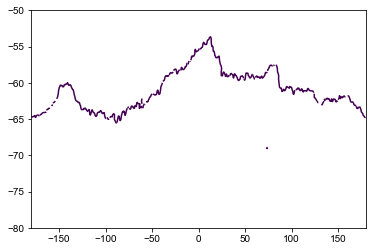

In [14]:
CS=contour(X, Y, sic_new, levels=['15'])


In [15]:
lons = []; lats = []

for i in range(len(CS.allsegs[0])):

    ln = CS.allsegs[0][i][:, 0]
    lt = CS.allsegs[0][i][:, 1]
    
    if i == 0:
        
        lons = ln
        lats = lt
        
    if i > 0:
        
        lons = np.append(lons, ln)
        lats = np.append(lats, lt)


In [16]:
i = np.argsort(lons)

lons = lons[i]
lats = lats[i]

i = lats > -66

lons = lons[i]
lats = lats[i]

In [55]:
import scipy.interpolate as sci

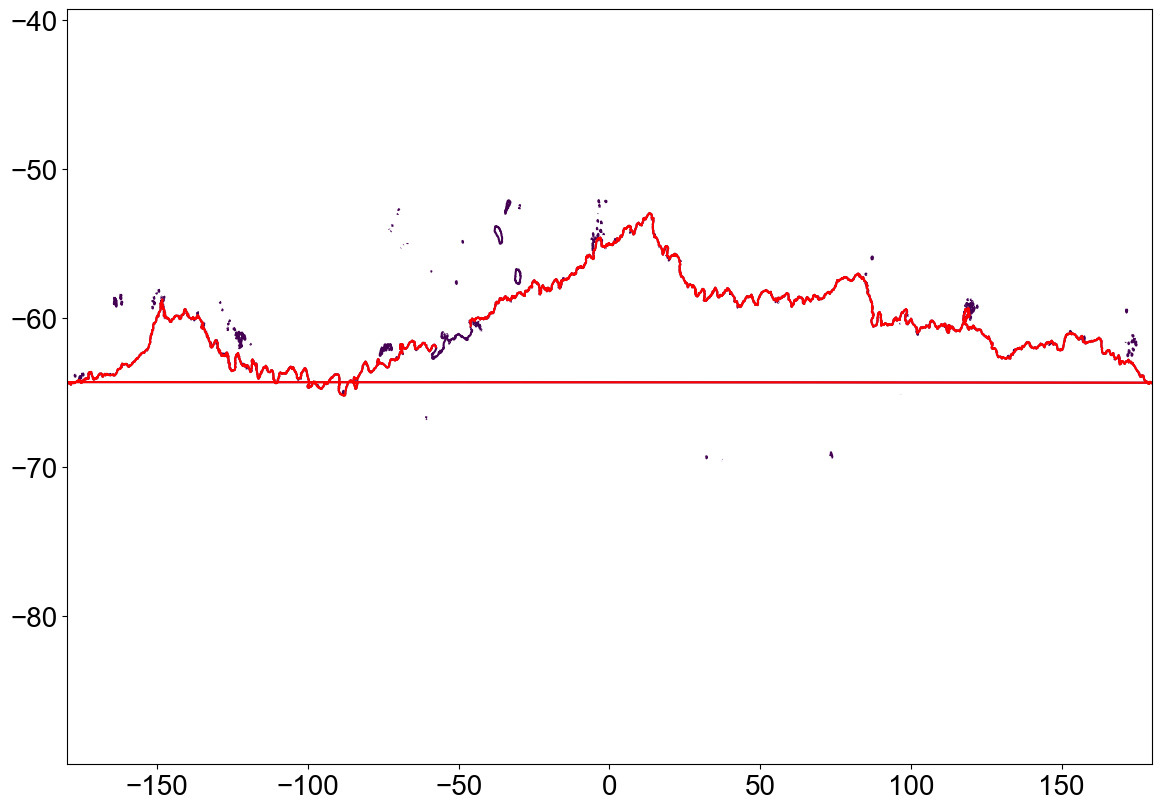

In [87]:
CS=contour(seaice.lon, seaice.lat, seaice.si.values, levels=['0.15'])

dat0 = CS.allsegs[0][:]
j = [len(dat0[i]) for i in range(len(dat0))]
dat0 = CS.allsegs[0][argmax(j)]

plt.plot(dat0[:,0],dat0[:,1], c='r')
# stf1 = dat0


Get fronts to define the ACC

In [56]:
path = '/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/adt/*.nc'

adt = xr.open_mfdataset(path)
adt = adt.mean(dim='time')

### Figure: Temperature and Salinity Trends Map

In [45]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

bottom = cm.get_cmap('OrRd', 128)
top = cm.get_cmap('PuBu_r', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


/Users/marcel/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/marcel/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/marcel/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/marcel/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


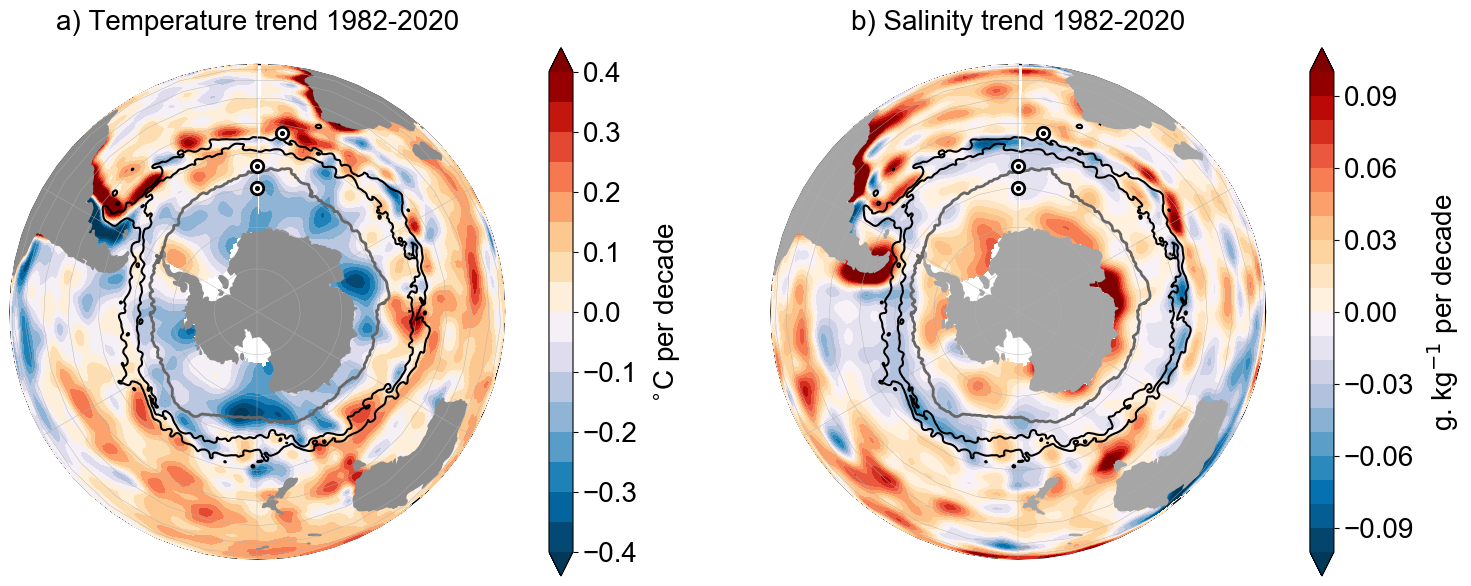

In [77]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=[18, 10])

ax= plt.subplot(1,2,1, projection=ccrs.Orthographic(0, -90))

im=ax.contourf(data.lon, data.lat, trend_T*10*12, levels=np.arange(-0.4, 0.45, 0.05), transform=ccrs.PlateCarree(), 
              extend='both', cmap=newcmp, zorder=4)
ax.add_feature(cfeature.LAND, color='0.55', zorder=5)
ax.gridlines(zorder=6, linewidth=0.3)
c=colorbar(mappable=im, ax=ax, shrink=0.7, orientation='vertical', pad=0.07)
c.set_label('$^{\circ}$C per decade', labelpad=11)
title('a) Temperature trend 1982-2020', fontsize=20, pad=25)
ax.contour(adt.longitude, adt.latitude, adt.adt, levels=[-0.48, 0.03], 
           colors='k', linewidths=1.5, linestyles='-', transform=ccrs.PlateCarree(), zorder=9)
ax.plot(lons, lats, c='0.4', zorder=9, transform=ccrs.PlateCarree(), lw=2)
ax.scatter([0, 0, 8], [-60, -54, -43], s=80, c='w', edgecolor='k', linewidth=2, transform=ccrs.PlateCarree(), zorder=10)
ax.scatter([0, 0, 8], [-60, -54, -43], s=7, c='k', transform=ccrs.PlateCarree(), zorder=11)

# subplot of the salinity trend statistics

ax = plt.subplot(1,2,2, projection=ccrs.Orthographic(0, -90))

im = ax.contourf(data.lon, data.lat, trend_S*10*12, levels=np.arange(-0.1, 0.11, 0.01), transform=ccrs.PlateCarree(), 
              extend='both', cmap=newcmp, zorder=4)
ax.add_feature(cfeature.LAND, color='0.65', zorder=5)
ax.gridlines(zorder=6, linewidth=0.3)
c=colorbar(mappable=im, ax=ax, shrink=0.7, orientation='vertical', pad=0.07)
c.set_label('g. kg$^{-1}$ per decade', labelpad=8)
title('b) Salinity trend 1982-2020', fontsize=20, pad=25)
ax.plot(lons, lats, c='0.4', zorder=9, transform=ccrs.PlateCarree(), lw=2)
ax.contour(adt.longitude, adt.latitude, adt.adt, levels=[-0.48, 0.03], 
           colors='k', linewidths=1.5, linestyles='-', transform=ccrs.PlateCarree(), zorder=9)

ax.scatter([0, 0, 8], [-60, -54, -43], s=80, c='w', edgecolor='k', linewidth=2, transform=ccrs.PlateCarree(), zorder=10)
ax.scatter([0, 0, 8], [-60, -54, -43], s=7, c='k', transform=ccrs.PlateCarree(), zorder=11)

Study site trends

In [170]:
rcParams["figure.figsize"] = [14, 8]
plt.rcParams["xtick.major.size"] = 6
font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 12}

matplotlib.rc('font', **font)

def plot_trend(ys, xs, ax):

    trend = np.polyfit(xs,ys,1)
    ax.plot(ys.time,ys,c='k', label='EN4')
    trendpoly = np.poly1d(trend) 
#     ax.plot(ys.time,trendpoly(xs), c='r', label='Trend')
#     ax.set_title(str(trend[0])+'x + '+str(trend[1]), fontsize=12)
    
    
    return np.round(trend[0], 4)

Text(0, 0.5, 'Temperature ($^{\\circ}$C)')

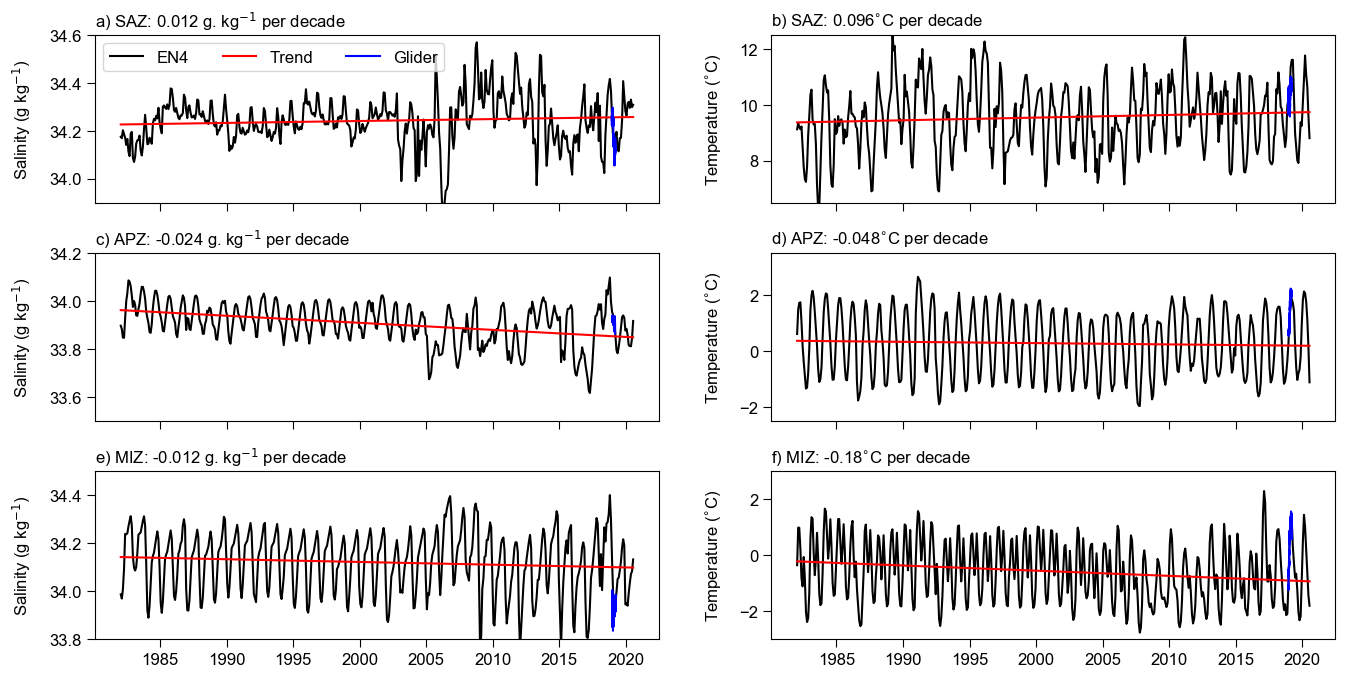

In [169]:
fig, ax = subplots(3, 2, figsize=[16, 8], sharex=True)
fig.subplots_adjust(hspace=0.3)

xs = np.arange(len(ys))

title_props = dict(fontsize=12, loc='left')

for i, a in enumerate(ax):
    
    if i==0:
        
        ys = oi_data.   salinity.sel(lat=-43, lon=8)
        yt = oi_data.temperature.sel(lat=-43, lon=8)-273.15

        ts = plot_trend(ys, xs, a[0])
        tt = plot_trend(yt, xs, a[1])
        
        a[0].set_title('a) SAZ: ' + str(ts*10*12) + ' g. kg$^{-1}$ per decade', **title_props)
        a[1].set_title('b) SAZ: ' + str(tt*10*12) + '$^{\circ}$C per decade', **title_props)
        
        a[0].plot(dat_saz.time, dat_saz.salt[10, :], c='b', label='Glider')
        a[1].plot(dat_saz.time, dat_saz.temp[10, :], c='b')
        
        a[0].legend(ncol=3)
        
    if i==1:
        
        ys = oi_data.   salinity.sel(lat=-54, lon=1)
        yt = oi_data.temperature.sel(lat=-54, lon=1)-273.15

        ts = plot_trend(ys, xs, a[0])
        tt = plot_trend(yt, xs, a[1]) 
        
        a[0].set_title('c) APZ: ' + str(ts*10*12) + ' g. kg$^{-1}$ per decade', **title_props)
        a[1].set_title('d) APZ: ' + str(tt*10*12) + '$^{\circ}$C per decade', **title_props)
        
        a[0].plot(dat_apz.time, dat_apz.salt[10, :], c='b')
        a[1].plot(dat_apz.time, dat_apz.temp[10, :], c='b')
        
    if i==2:
        
        ys = oi_data.   salinity.sel(lat=-60, lon=1)
        yt = oi_data.temperature.sel(lat=-60, lon=1)-273.15

        ts = plot_trend(ys, xs, a[0])
        tt = plot_trend(yt, xs, a[1]) 
        
        a[0].set_title('e) MIZ: ' + str(ts*10*12) + ' g. kg$^{-1}$ per decade', **title_props)
        a[1].set_title('f) MIZ: ' + str(tt*10*12) + '$^{\circ}$C per decade', **title_props)
        
        a[0].plot(dat_miz.time, dat_miz.salt[10, :], c='b')
        a[1].plot(dat_miz.time, dat_miz.temp[10, :], c='b')
        
ax[0, 0].set_ylim(33.9, 34.6); ax[0, 0].set_ylabel('Salinity (g kg$^{-1}$)', labelpad=12)
ax[1, 0].set_ylim(33.5, 34.2); ax[1, 0].set_ylabel('Salinity (g kg$^{-1}$)', labelpad=12)
ax[2, 0].set_ylim(33.8, 34.5); ax[2, 0].set_ylabel('Salinity (g kg$^{-1}$)', labelpad=12)

ax[0, 1].set_ylim(6.5, 12.5); ax[0, 1].set_ylabel('Temperature ($^{\circ}$C)', labelpad=12)
ax[1, 1].set_ylim(-2.5, 3.5); ax[1, 1].set_ylabel('Temperature ($^{\circ}$C)', labelpad=12)
ax[2, 1].set_ylim(-3, 3); ax[2, 1].set_ylabel('Temperature ($^{\circ}$C)', labelpad=12)

Load in the L2 processes glider data

In [80]:
dat_saz = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/sg542_saz_L2.nc')
dat_apz = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/slocum_apz_L2.nc')
dat_miz = xr.open_dataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/sg643_miz_L2.nc')

In [143]:
t_sc_saz = oi_data.sel(lat=-43, lon=8).groupby('time.month').mean().temperature.values
s_sc_saz = oi_data.sel(lat=-43, lon=8).groupby('time.month').mean().salinity.values

t_sc_apz = oi_data.sel(lat=-54, lon=1).groupby('time.month').mean().temperature.values
s_sc_apz = oi_data.sel(lat=-54, lon=1).groupby('time.month').mean().salinity.values

t_sc_miz = oi_data.sel(lat=-60, lon=1).groupby('time.month').mean().temperature.values
s_sc_miz = oi_data.sel(lat=-60, lon=1).groupby('time.month').mean().salinity.values

/Users/marcel/anaconda3/lib/python3.7/site-packages/xarray/core/groupby.py:749: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)
/Users/marcel/anaconda3/lib/python3.7/site-packages/xarray/core/groupby.py:749: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)
/Users/marcel/anaconda3/lib/python3.7/site-packages/xarray/core/groupby.py:749: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)
/Users/marcel/anaconda3/lib/python3.7/site-packages/xarray/core/groupby.py:749: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0

In [144]:
t_sc_saz = np.append(np.tile(t_sc_saz, 38), t_sc_saz[:7])-273.15
t_sc_apz = np.append(np.tile(t_sc_apz, 38), t_sc_apz[:7])-273.15
t_sc_miz = np.append(np.tile(t_sc_miz, 38), t_sc_miz[:7])-273.15

s_sc_saz = np.append(np.tile(s_sc_saz, 38), s_sc_saz[:7])
s_sc_apz = np.append(np.tile(s_sc_apz, 38), s_sc_apz[:7])
s_sc_miz = np.append(np.tile(s_sc_miz, 38), s_sc_miz[:7])

Text(0, 0.5, 'Temperature ($^{\\circ}$C)')

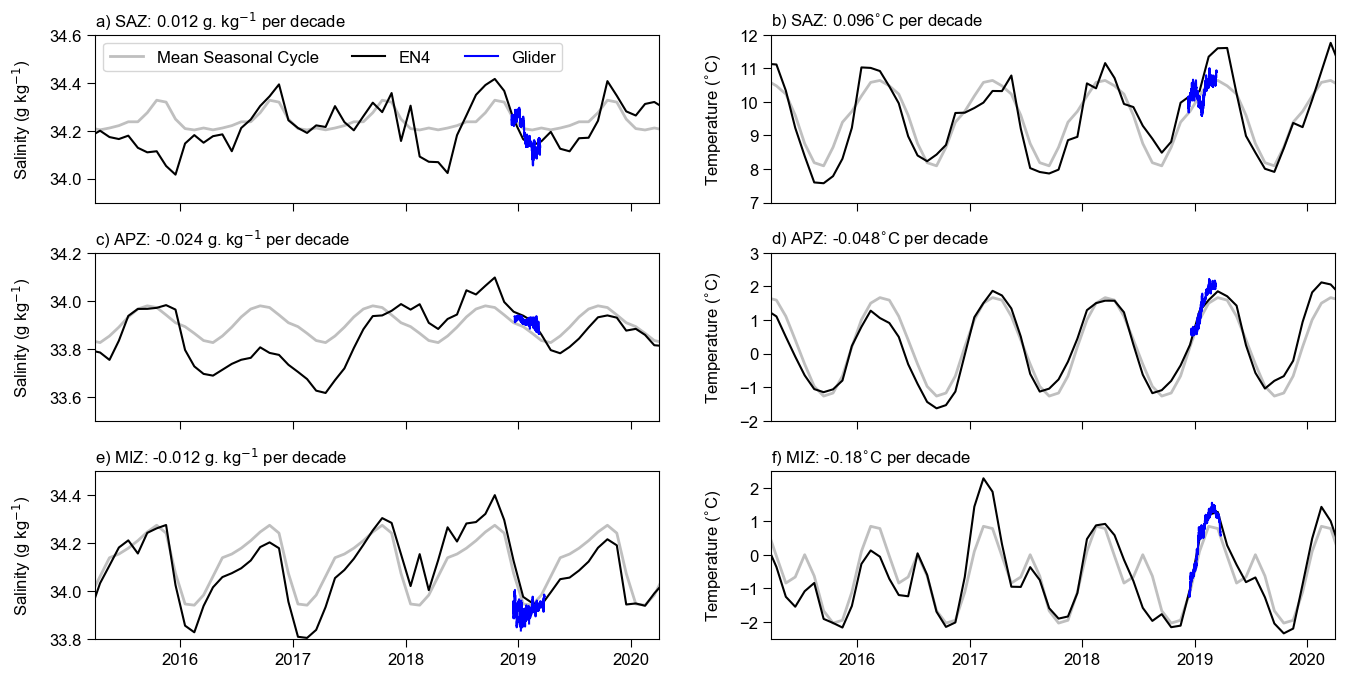

In [173]:
plt.rcParams["xtick.major.size"] = 6
plt.rcParams["ytick.major.size"] = 6
font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 12}

matplotlib.rc('font', **font)

fig, ax = subplots(3, 2, figsize=[16, 8], sharex=True)
fig.subplots_adjust(hspace=0.3)

xs = np.arange(len(ys))

ax[0,0].plot(oi_data.time, s_sc_saz, '0.75', lw=2, label='Mean Seasonal Cycle')
ax[1,0].plot(oi_data.time, s_sc_apz, '0.75', lw=2)
ax[2,0].plot(oi_data.time, s_sc_miz, '0.75', lw=2)

ax[0,1].plot(oi_data.time, t_sc_saz, '0.75', lw=2)
ax[1,1].plot(oi_data.time, t_sc_apz, '0.75', lw=2)
ax[2,1].plot(oi_data.time, t_sc_miz, '0.75', lw=2)

title_props = dict(fontsize=12, loc='left')

for i, a in enumerate(ax):
    
    if i==0:
        
        ys = oi_data.   salinity.sel(lat=-43, lon=8)
        yt = oi_data.temperature.sel(lat=-43, lon=8)-273.15

        ts = plot_trend(ys, xs, a[0])
        tt = plot_trend(yt, xs, a[1])
        
        a[0].set_title('a) SAZ: ' + str(ts*10*12) + ' g. kg$^{-1}$ per decade', **title_props)
        a[1].set_title('b) SAZ: ' + str(tt*10*12) + '$^{\circ}$C per decade', **title_props)
        
        a[0].plot(dat_saz.time, dat_saz.salt[10, :], c='b', label='Glider')
        a[1].plot(dat_saz.time, dat_saz.temp[10, :], c='b')
        
        a[0].legend(ncol=3, loc=2)
        
    if i==1:
        
        ys = oi_data.   salinity.sel(lat=-54, lon=1)
        yt = oi_data.temperature.sel(lat=-54, lon=1)-273.15

        ts = plot_trend(ys, xs, a[0])
        tt = plot_trend(yt, xs, a[1]) 
        
        a[0].set_title('c) APZ: ' + str(ts*10*12) + ' g. kg$^{-1}$ per decade', **title_props)
        a[1].set_title('d) APZ: ' + str(tt*10*12) + '$^{\circ}$C per decade', **title_props)
        
        a[0].plot(dat_apz.time, dat_apz.salt[10, :], c='b')
        a[1].plot(dat_apz.time, dat_apz.temp[10, :], c='b')
        
    if i==2:
        
        ys = oi_data.   salinity.sel(lat=-60, lon=1)
        yt = oi_data.temperature.sel(lat=-60, lon=1)-273.15

        ts = plot_trend(ys, xs, a[0])
        tt = plot_trend(yt, xs, a[1]) 
        
        a[0].set_title('e) MIZ: ' + str(ts*10*12) + ' g. kg$^{-1}$ per decade', **title_props)
        a[1].set_title('f) MIZ: ' + str(tt*10*12) + '$^{\circ}$C per decade', **title_props)
        
        a[0].plot(dat_miz.time, dat_miz.salt[10, :], c='b')
        a[1].plot(dat_miz.time, dat_miz.temp[10, :], c='b')
        
        a[0].set_xlim('2015-03-31', '2020-03-31')
        a[1].set_xlim('2015-03-31', '2020-03-31')
        
ax[0, 0].set_ylim(33.9, 34.6); ax[0, 0].set_ylabel('Salinity (g kg$^{-1}$)', labelpad=12)
ax[1, 0].set_ylim(33.5, 34.2); ax[1, 0].set_ylabel('Salinity (g kg$^{-1}$)', labelpad=12)
ax[2, 0].set_ylim(33.8, 34.5); ax[2, 0].set_ylabel('Salinity (g kg$^{-1}$)', labelpad=12)

ax[0, 1].set_ylim(7, 12); ax[0, 1].set_ylabel('Temperature ($^{\circ}$C)', labelpad=12)
ax[1, 1].set_ylim(-2, 3); ax[1, 1].set_ylabel('Temperature ($^{\circ}$C)', labelpad=12)
ax[2, 1].set_ylim(-2.5, 2.5); ax[2, 1].set_ylabel('Temperature ($^{\circ}$C)', labelpad=12)

Plot only the time period for which the gliders were in the water

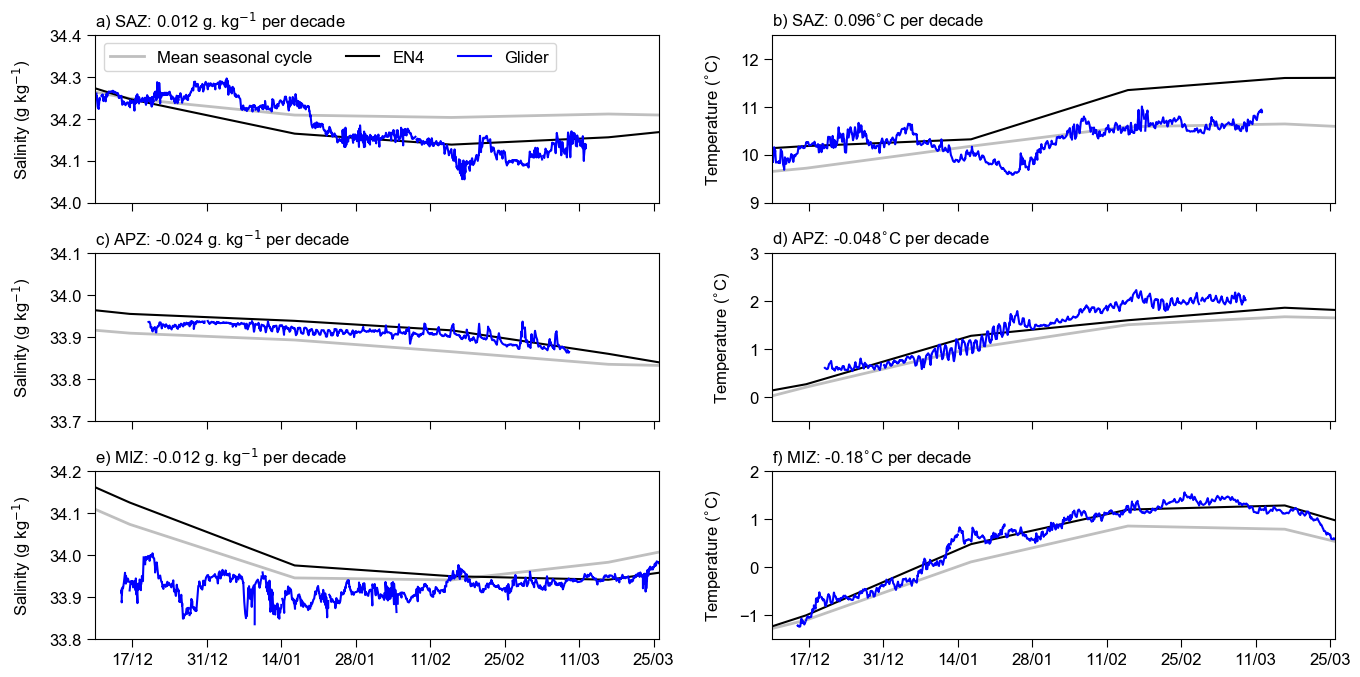

In [180]:
plt.rcParams["xtick.major.size"] = 6
plt.rcParams["ytick.major.size"] = 6
font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 12}

matplotlib.rc('font', **font)

fig, ax = subplots(3, 2, figsize=[16, 8], sharex=True)
fig.subplots_adjust(hspace=0.3)

xs = np.arange(len(ys))

ax[0,0].plot(oi_data.time, s_sc_saz, '0.75', lw=2, label='Mean seasonal cycle')
ax[1,0].plot(oi_data.time, s_sc_apz, '0.75', lw=2)
ax[2,0].plot(oi_data.time, s_sc_miz, '0.75', lw=2)

ax[0,1].plot(oi_data.time, t_sc_saz, '0.75', lw=2)
ax[1,1].plot(oi_data.time, t_sc_apz, '0.75', lw=2)
ax[2,1].plot(oi_data.time, t_sc_miz, '0.75', lw=2)

title_props = dict(fontsize=12, loc='left')

for i, a in enumerate(ax):
    
    if i==0:
        
        ys = oi_data.   salinity.sel(lat=-43, lon=8)
        yt = oi_data.temperature.sel(lat=-43, lon=8)-273.15

        ts = plot_trend(ys, xs, a[0])
        tt = plot_trend(yt, xs, a[1])
        
        a[0].set_title('a) SAZ: ' + str(ts*10*12) + ' g. kg$^{-1}$ per decade', **title_props)
        a[1].set_title('b) SAZ: ' + str(tt*10*12) + '$^{\circ}$C per decade', **title_props)
        
        a[0].plot(dat_saz.time, dat_saz.salt[10, :], c='b', label='Glider')
        a[1].plot(dat_saz.time, dat_saz.temp[10, :], c='b')
        
        a[0].legend(loc=2, ncol=3)
        
    if i==1:
        
        ys = oi_data.   salinity.sel(lat=-54, lon=1)
        yt = oi_data.temperature.sel(lat=-54, lon=1)-273.15

        ts = plot_trend(ys, xs, a[0])
        tt = plot_trend(yt, xs, a[1]) 
        
        a[0].set_title('c) APZ: ' + str(ts*10*12) + ' g. kg$^{-1}$ per decade', **title_props)
        a[1].set_title('d) APZ: ' + str(tt*10*12) + '$^{\circ}$C per decade', **title_props)
        
        a[0].plot(dat_apz.time, dat_apz.salt[10, :], c='b')
        a[1].plot(dat_apz.time, dat_apz.temp[10, :], c='b')
        
    if i==2:
        
        ys = oi_data.   salinity.sel(lat=-60, lon=1)
        yt = oi_data.temperature.sel(lat=-60, lon=1)-273.15

        ts = plot_trend(ys, xs, a[0])
        tt = plot_trend(yt, xs, a[1]) 
        
        a[0].set_title('e) MIZ: ' + str(ts*10*12) + ' g. kg$^{-1}$ per decade', **title_props)
        a[1].set_title('f) MIZ: ' + str(tt*10*12) + '$^{\circ}$C per decade', **title_props)
        
        a[0].plot(dat_miz.time, dat_miz.salt[10, :], c='b')
        a[1].plot(dat_miz.time, dat_miz.temp[10, :], c='b')
        
        a[0].set_xlim('2018-12-10', '2019-03-26')
        a[1].set_xlim('2018-12-10', '2019-03-26')
        
ax[0, 0].set_ylim(34, 34.4); ax[0, 0].set_ylabel('Salinity (g kg$^{-1}$)', labelpad=12)
ax[1, 0].set_ylim(33.7, 34.1); ax[1, 0].set_ylabel('Salinity (g kg$^{-1}$)', labelpad=12)
ax[2, 0].set_ylim(33.8, 34.2); ax[2, 0].set_ylabel('Salinity (g kg$^{-1}$)', labelpad=12)

ax[0, 1].set_ylim(9, 12.5); ax[0, 1].set_ylabel('Temperature ($^{\circ}$C)', labelpad=12)
ax[1, 1].set_ylim(-0.5, 3); ax[1, 1].set_ylabel('Temperature ($^{\circ}$C)', labelpad=12)
ax[2, 1].set_ylim(-1.5, 2); ax[2, 1].set_ylabel('Temperature ($^{\circ}$C)', labelpad=12)

weeks = mdates.WeekdayLocator(byweekday=MO, interval=2)
yearsFmt = mdates.DateFormatter("%d/%m")

ax[0, 0].xaxis.set_major_locator(weeks) 
ax[0, 0].xaxis.set_major_formatter(yearsFmt) 